# Clasificador Bayesiano de Idiomas

Parara reponer las 4 horas de la semana pasada, y como ejercicio de las cosas que ya vimos en clase, quiero que hagan un clasificador de idioma de 3 o 4 lenguas distintas. La característica que utilizará el clasificador, será n-gramas (caracteres) y ustedes deben determinar una n óptima basados en las métricas de evaluación dadas anteriormente. El clasificador, hagan un clasificador tipo Bayesiano (programenlo ustedes, por favor). Utilicen el truco de los exponentes que vimos la penúltima vez.

Probabilidad que una palabra $w$ esté en un documento de la clase $C$

$$ p(w_i \mid C) $$

Probabilidad de que un documento $D$, contenga todas las palabras $w_i$, dada una clase $C$

$$ p(D\mid C)=\prod_i p(w_i \mid C) $$

Naive Bayes (NB)

$$ c_{NB} = \underset{c \in C}{\mathrm{argmax}} \ p(c_i)\prod_i p(w_i \mid c_i) $$

$$ c_{NB} = \underset{c \in C}{\mathrm{argmax}} \ \log p(c_i) + \sum_i \log p(w_i \mid c_i) $$

Laplace Smoothing

$$ \hat{p}(w \mid c) = \frac{\mathrm{count}(w, c) + 1}{\mathrm{count}(c) + \vert V \vert} $$

In [2]:
# import nltk
# p(C \vert F_1,\dots,F_n) = \frac{p(C) \ p(F_1,\dots,F_n\vert C)}{p(F_1,\dots,F_n)}
import numpy as np 
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
n = 2 # Agrupar los documentos en n caractéres
clases = {
    0 : 'es',
    1 : 'pt',
    2 : 'en',
}
colors = [
    'r',
    'g',
    'b'
]
corpus = {
    index : open(f'corpus/{lang}.txt', 'r', encoding='utf-8').readlines() 
    for index, lang in clases.items()
}

Función para obtener los n-gramas de una cadena de caracteres

In [4]:
# https://www.nltk.org/_modules/nltk/util.html#ngrams
def obtener_ngramas(text = "", n=2):
    """Función para obtener los ngramas de una cadena de caracteres
    :param str text
    :param n int
    """
    seq = iter(text)
    ngramas = []
    ngrama = ""
    while n > 1:
        # PEP 479, prevent RuntimeError from being raised when StopIteration bubbles out of generator
        try:
            next_item = next(seq)
        except StopIteration:
            # no more data, terminate the generator
            return
        ngrama += next_item
        n -= 1
    for item in seq:
        ngrama += item
        yield ngrama
        ngrama = ngrama[1:]

In [5]:
ngramas = {
    index : [ngrama for sent in corpus_lang for ngrama in (obtener_ngramas(sent, n))]
    for index, corpus_lang in corpus.items()
}
# bigramas = {
#     index : [ch1 + ch2 for sent in corpus_lang for ch1, ch2 in zip(sent[:-1], sent[1:])]
#     for index, corpus_lang in corpus.items()
# }

In [6]:
for index, ngramas_lang in ngramas.items():
    print('Lenguaje: ', clases[index])
    print('N-gramas: ', len(ngramas_lang))
    print(ngramas_lang[:15])
    print('')

Lenguaje:  es
N-gramas:  21391
['Se', 'e ', ' t', 'to', 'om', 'ma', 'ar', 'rá', 'á ', ' c', 'co', 'om', 'mo', 'o ', ' p']

Lenguaje:  pt
N-gramas:  21716
['Se', 'er', 'rá', 'á ', ' t', 'to', 'om', 'ma', 'ad', 'do', 'o ', ' c', 'co', 'om', 'mo']

Lenguaje:  en
N-gramas:  21657
['It', 't ', ' w', 'wi', 'il', 'll', 'l ', ' b', 'be', 'e ', ' t', 'ta', 'ak', 'ke', 'en']



In [15]:
todos_ngramas = [ngrama for ngramas_lang in ngramas.values() for ngrama in ngramas_lang]
tam_corpus = len(todos_ngramas)
print(f'Tamaño corpus: {tam_corpus} n-gramas')
print(todos_ngramas[0:10])

Tamaño corpus: 64764 n-gramas
['Se', 'e ', ' t', 'to', 'om', 'ma', 'ar', 'rá', 'á ', ' c']


### Probabilidades a priori

Calculo las probabilidades a priori de las clases

In [16]:
prob_priori = {
    index : len(ngramas_lang)/tam_corpus
    for index, ngramas_lang in ngramas.items()
}
prob_priori

{0: 0.3302915199802359, 1: 0.33530973997900065, 2: 0.33439874004076336}

### Verisimilitud (Likelihood)

Ahora, calculo la probabilidad de cada n-grama dada la clase con Laplace Smoothing

Primero, cuento las ocurrencias de cada n-grama en cada clase 

In [20]:
freq_ngramas = {
    index : Counter(ngramas_lang)
    for index, ngramas_lang in ngramas.items()
}
for index, counters in freq_ngramas.items():
    print(f'Idioma: {clases[index]}')
    print(f'Número de tipos: {len(counters)}')
    print(counters.most_common(10), '\n')

Idioma: es
Número de tipos: 847
[('e ', 592), ('a ', 583), ('s ', 497), ('de', 448), (' d', 424), (' e', 403), ('o ', 388), ('en', 366), ('n ', 363), ('es', 321)] 

Idioma: pt
Número de tipos: 857
[('o ', 661), ('s ', 647), ('e ', 568), ('a ', 540), (' d', 442), (' e', 349), ('os', 341), ('de', 318), (' a', 305), ('do', 301)] 

Idioma: en
Número de tipos: 861
[('e ', 671), (' t', 512), ('th', 457), (' a', 423), ('he', 413), ('s ', 402), ('in', 341), ('d ', 339), ('er', 313), ('n ', 303)] 



Ahora, la frecuencia total de los tipos en todo el corpus

In [26]:
freq_total = sum(freq_ngramas.values(), Counter())
tipos = [tipo for tipo in freq_total.keys()]
print(f'Número de tipos: {len(tipos)}')
print(tipos[:10])
# plt.figure()
# plt.title(f'Rango vs frecuencia en bigramas (TOTAL)')
# freq = [fr[1] for fr in freq_total.most_common()]
# ranks = range(1, len(freq)+1)
# plt.scatter(np.log(ranks), np.log(freq), color='#9f0ff0')
# plt.show()

Número de tipos: 1328
['Se', 'e ', ' t', 'to', 'om', 'ma', 'ar', 'rá', 'á ', ' c']


$ \hat{p}(w \mid c) = \frac{\mathrm{count}(w, c) + 1}{\mathrm{count}(c) + \vert V \vert} $

In [44]:
likelihoods = {
    tipo : {
        lang : (freq[tipo] + 1) / (len(freq) + tam_corpus)
        for lang, freq in freq_ngramas.items()
    }
    for tipo in tipos
}
print(likelihoods['ás'])

{0: 0.00039627501486031304, 1: 0.00010667316865027964, 2: 1.5238095238095238e-05}


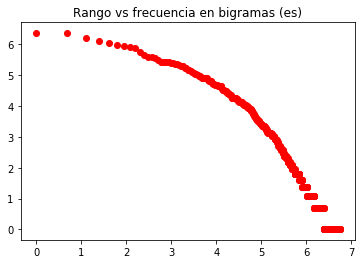

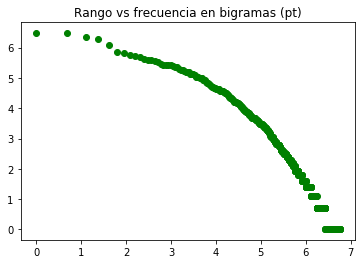

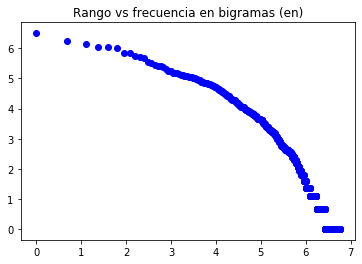

In [9]:
for index, counters in freq_bigamas.items():
    plt.figure()
    plt.title(f'Rango vs frecuencia en bigramas ({clases[index]})')
    freq = [fr[1] for fr in counters.most_common()]
    ranks = range(1, len(freq)+1)
    plt.scatter(np.log(ranks), np.log(freq), color=colors[index])
    plt.show()

1330


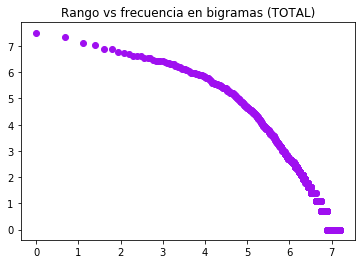

In [15]:
total = sum(freq_bigamas.values(), Counter())
print(len(total.most_common()))
plt.figure()
plt.title(f'Rango vs frecuencia en bigramas (TOTAL)')
freq = [fr[1] for fr in total.most_common()]
ranks = range(1, len(freq)+1)
plt.scatter(np.log(ranks), np.log(freq), color='#9f0ff0')
plt.show()

In [16]:
hapax = []
for item in reversed(total.most_common()):
    if (item[1]==1):
        hapax.append(item)
    else:
        break
len(hapax)

342

In [64]:
from itertools import count
from collections import defaultdict
from functools import partial

def hashing_v1(seq):
    mapping = defaultdict(partial(next, count()))
    return [mapping[tuple(el)] for el in seq]

def hashing_v2(seq):
    mapping = defaultdict(partial(next, count()))
    result = []
    for le in seq:
        le.flags.writeable = False
        result.append(mapping[le.data])
    return result